In [1]:
import csv
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib as mpl
import scipy
import math
import copy
import os
from datetime import datetime
import random
import multiprocessing
import importlib
import inspect

import bioscrape as bs
import bioscrape.lineage as bs_lineage

import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
# sns.set(rc=rc)
# sns.set(style = "ticks")

sns.set_context('paper')

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

# Utility funcs

In [2]:
def make_growth_model(rxns, species, params, initial_conditions):
    '''
    Adds some scaffolding to a model to put it in an exponentially-growing cell 
    with growth rate params['k_gamma']. Parameters are of the same type and 
    specification as used by bioscrape.types.Model.
    '''
    m = bs_lineage.LineageModel(reactions = rxns, 
                              parameters = params,
                              species = species,
                              initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if there's 
    # no DNA present. 
    m.create_volume_rule("ode", {"equation": "volume * _k_gamma"})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

# Deterministic:

In [3]:
# All parameters in units of 1/sec or 1/nM/sec
cas_params = dict()
cas_params['k_gamma']    = math.log(2) / (30 * 60)
cas_params['k_gRNA_prod_rate']   = 5.0 / 60 
cas_params['k_gRNA_deg_rate']    = math.log(2) / 100.0
cas_params['k_dCas_prod_rate']   = 3 * 1.0 / 60 # 3x other simulations
cas_params['k_dCas_deg_rate']    = 0 * cas_params['k_gamma']
cas_params['k_gRNA_bind']      = math.log(2) / 375.0
cas_params['k_gRNA_unbind']    = 0
cas_params['k_complex_bind']   = math.log(2) / 60.0
cas_params['k_complex_unbind'] = 0 #params['k_complex_bind'] / 1000.0 #<-- Just a guess!
cas_params['k_gRNA_leak_rate']   = 0# params['gRNA_prod_rate'] / 100.0

In [4]:
def make_CRISPRessilator_model(params, initial_conditions, lineage = False):
    '''
    Assumes abundant dCas, instant and perfect binding.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas:g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas:g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas:g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}:g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}:g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions)
        return m

In [5]:
def plot_guides(simulation_data, t_start = 0, 
                t_end = None, colors = None, title = "",
                filename = None, show = True,
                show_legend = True, figsize = None):
    '''
    Helper function for plotting simulations of gRNA-based 
    circuits. Plots the total amount of each gRNA (free, bound
    to dCas, and bound to DNA). 
    
    params:
        simulation_data -- A SimulationModel object specifying the model,
                            simulated trajectories, and time division 
                            used to plot. 
            model -- A SimpleCasNetwork object specifying the gRNA circuit.
            solution -- A 2D numpy array holding results of a simulation
                        with model.
            ts -- A 1D array of times.
        t_start -- First index to plot from ts. Default 0.
        t_end -- Last index to plot from ts. Default to include everything.
        colors -- Optional map from guide names to what color they should
                    be plotted.
        title -- Optional title of the figure.
        filename -- Optional string specifying a filename. If set, will
                    save the figure.
        show -- Flags whether or not to display the plot. Defaults to True.
                Use if you want to save a bunch of figures without 
                displaying them all in Jupyter.
    '''
    ####
    # TEMPORARY NAME TWEAK FOR DISPLACING SIMULATIONS
    ####
    if filename:
        filename = filename[:-4] + "_with_displacing_leak." + filename[-4:]
    
    model    = simulation_data.model
    solution = simulation_data.solution
    ts       = simulation_data.ts
    
    guides = model.get_guide_names()
    names = model.get_names()

    if colors == None:
        if len(guides) == 3:
            color_list = ["#1b9e77", "#d95f02", "#7570b3"]
        elif len(guides) == 5:
            color_list = ['#e41a1c', '#377eb8', '#4daf4a', 
                          '#984ea3', '#ff7f00']
        else:
            color_list = [None] * len(guides)
        colors = dict()
        for i, color in enumerate(color_list):
            colors[guides[i]] = color
                
    if t_end == None:
        t_end = solution.shape[0]

    plt.clf()
    plt.figure(figsize = (10,5) if figsize is None else figsize)
    for name in guides:
        guide_amts = copy.deepcopy(solution[:,names[name]])
        for other_name in names:
            if other_name == name:
                continue
            if 'dCas_' + name in other_name:
                guide_amts += solution[:,names[other_name]]
        plt.plot(ts[t_start:t_end]/3600.0, guide_amts[t_start:t_end], 
                 label = "total " + name, color = colors[name])
    
    plt.xlabel("Time (hr)")
    plt.ylabel("Concentration (nM)")
    plt.title(title)
#     plt.legend(loc='best')
    if show_legend:
        lgd = plt.legend(bbox_to_anchor=(1.05, 1.05), loc = 'upper left')
    if filename:
        if show_legend:
            plt.savefig(filename, dpi=400, bbox_extra_artists=(lgd,), bbox_inches='tight')
        else:
            plt.savefig(filename, dpi=400, bbox_inches='tight')            
    if show:
        plt.tight_layout()
        plt.show()

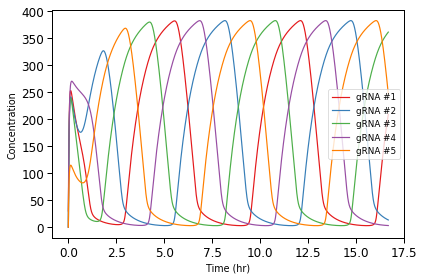

In [6]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
simple_CRISPRessilator_m = make_CRISPRessilator_model(cas_params, initial_conditions, lineage = False)
ts = np.linspace(0, 60000, 10000)
simple_CRISPR_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRessilator_m, stochastic = False)

color_list = ['#e41a1c', '#377eb8', '#4daf4a', 
                          '#984ea3', '#ff7f00']
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_CRISPR_results[f"g{j}"] + simple_CRISPR_results[f"dCas:g{j}"] + simple_CRISPR_results[f"DNA{prev_i}:g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.show()


# Stochastic

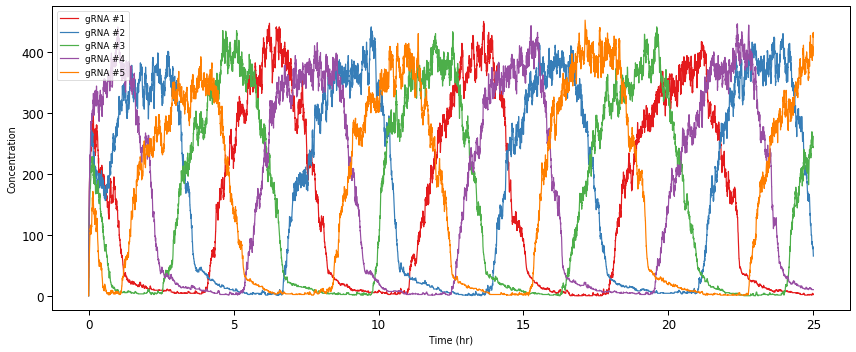

In [7]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
ts = np.linspace(0, 90000, 10000)
simple_stoch_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRessilator_m, stochastic = True)

color_list = ['#e41a1c', '#377eb8', '#4daf4a', 
                          '#984ea3', '#ff7f00']
plt.figure(figsize = (12,5))
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_stoch_results[f"g{j}"] + simple_stoch_results[f"dCas:g{j}"] + simple_stoch_results[f"DNA{prev_i}:g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.show()


# Lineages

### Trivial model (bad)

In [8]:
def make_CRISPRessilator_trivial(params, initial_conditions, lineage = False):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (trivial)
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}:g{i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas:{i}"], 'massaction', {'k': params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas:g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas:g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas:g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}:g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}:g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions)
        return m

In [9]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 20
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 400)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

trivial_model = make_CRISPRessilator_trivial(cas_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
trivial_results = bs_lineage.py_SimulateTurbidostat(initial_cell_states = 16, 
                                                  timepoints = temp_ts,
                                                  sample_times = sample_times,
                                                  population_cap = 16,
                                                  Model = trivial_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

execution time: 0:00:05.901312


/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

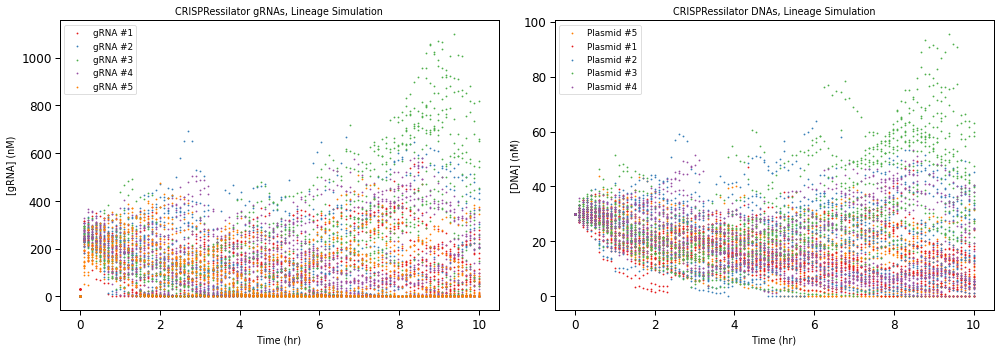

In [10]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in trivial_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = trivial_model.get_species2index()[f"g{i}"]
    dCas_idx = trivial_model.get_species2index()[f"dCas:g{i}"]
    dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}:g{i}"]
    bare_dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}"]

    
    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[i] + dCas_gRNA[i] + dna_gRNA[i] for i in range(len(all_states))]
    total_dna = [bare_dna[i] + dna_gRNA[i] for i in range(len(all_states))]

    plt.subplot(121)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1], s = 1)
    plt.subplot(122)
    plt.scatter(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1], s = 1)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNA] (nM)")
plt.title(f"CRISPRessilator gRNAs, Lineage Simulation")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRessilator DNAs, Lineage Simulation")
plt.legend()
plt.tight_layout()
plt.show()

### Dummy model

In [11]:
def make_CRISPRessilator_dummy(params, initial_conditions, lineage = False):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (dummy-triggered)
        rxns.append(([], [f"R{i}"], 'massaction', {'k': initial_conditions["DNA1"]*params['k_gamma']}))
        rxns.append(([f"DNA{i}", f"R{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': 10*params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}:g{i}", f"R{i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas:{i}"], 'massaction', {'k': 10*params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas:g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas:g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas:g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}:g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}:g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions)
        return m

In [12]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 50
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 400)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_model = make_CRISPRessilator_dummy(cas_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_results = bs_lineage.py_SimulateTurbidostat(initial_cell_states = 1, 
                                                  timepoints = temp_ts,
                                                  sample_times = sample_times,
                                                  population_cap = 1,
                                                  Model = dummy_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

execution time: 0:00:01.778225


/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

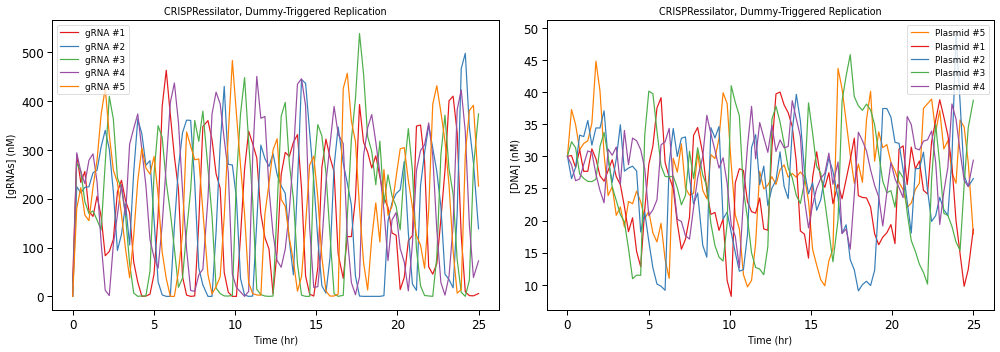

In [13]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_model.get_species2index()[f"dCas:g{i}"]
    dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}:g{i}"]
    bare_dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRessilator, Dummy-Triggered Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRessilator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

### B&P

In [59]:
def make_CRISPRessilator_bp(params, initial_conditions, lineage = False):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with B&P-based ColE1 mechanism.
    '''
    if not lineage:
        raise ValueError("This should always be called as a lineage.")
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}:g{i}"]:
            rxns.append(([f"{DNA}"], [f"{DNA}_RIIs"], "massaction", {"k": "k_II"}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"{DNA}_RI"], "massaction", {"k": "k_I"}))
            rxns.append(([f"{DNA}_RIIs"], [f"{DNA}_RIIL"], "massaction", {"k": "k_L"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}"], "massaction", {"k": "k_mL"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}_p"], "massaction", {"k": "k_p"}))
            # Replication strips off dCas
            rep_prods = [f"DNA{prev_i}"]*2
            if DNA == f"DNA{prev_i}:g{i}":
                rep_prods += [f"dCas:g{i}"]
            rxns.append(([f"{DNA}_p"], rep_prods, "massaction", {"k": "k_D"}))
            rxns.append(([f"{DNA}_RIIs", f"{DNA}_RI"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_RIIs", f"{DNA}_RI"], "massaction", {"k": "k_m1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_II_Is"], "massaction", {"k": "k_2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_m2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}"], "massaction", {"k": "k_mC"}))
            rxns.append(([f"{DNA}_RI"], [], "massaction", {"k": "k_gamma_I"}))
        
        # Everything else
        for dna_suffix in ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            rxns.append(([f"{DNA}"], [f"{DNA}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas:g{i}", f"{DNA}"], [f"DNA{prev_i}:g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas:g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas:g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
    else:
        m = make_growth_model(rxns, species, params, initial_conditions)
        return m

In [60]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

bp_params = copy.copy(cas_params)
bp_params["k_II"] = 0.25
bp_params["k_L"] = 12.0
bp_params["k_mL"] = 4.3
bp_params["k_p"] = 4.3
bp_params["k_D"] = 5
bp_params["k_1"] = 0.15
bp_params["k_m1"] = 48
bp_params["k_2"] = 44
bp_params["k_m2"] = 0.085
bp_params["k_mC"] = 17
bp_params["k_I"] = 6
bp_params["k_gamma_I"] = .35
bp_params["k_gamma"] = math.log(2)/30

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 10
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 400)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

bp_model = make_CRISPRessilator_bp(bp_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
bp_results = bs_lineage.py_SimulateTurbidostat(initial_cell_states = 1, 
                                                  timepoints = temp_ts,
                                                  sample_times = sample_times,
                                                  population_cap = 1,
                                                  Model = bp_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

execution time: 0:10:59.715867


/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

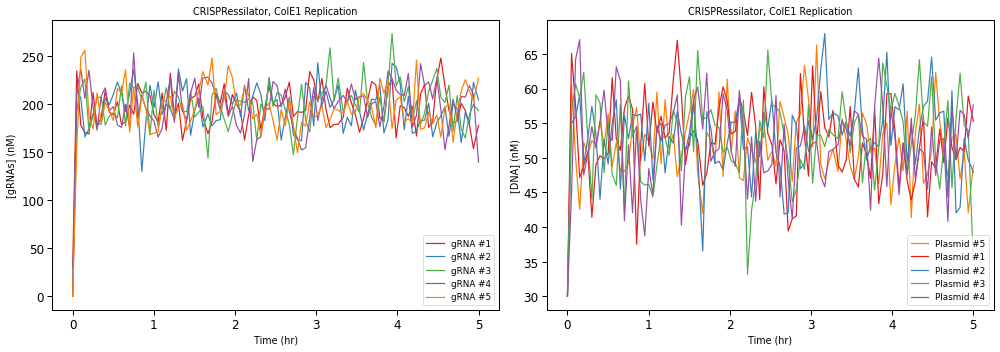

In [61]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in bp_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
#     gRNA_idx = bp_model.get_species2index()[f"g{i}"]
#     dCas_idx = bp_model.get_species2index()[f"dCas:g{i}"]
#     dna_idx = bp_model.get_species2index()[f"DNA{prev_i}:g{i}"]
#     bare_dna_idx = bp_model.get_species2index()[f"DNA{prev_i}"]

#     bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
#     dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
#     dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
#     bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}:g{i}"]
    dna_suffixes = ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}:g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRessilator, ColE1 Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRessilator, ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()

### Simplified B&P

In [42]:
def make_CRISPRessilator_simple_bp(params, initial_conditions, lineage = False):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with simplified ColE1 mechanism.
    '''
    if not lineage:
        raise ValueError("This should always be called as a lineage.")
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (Simplified B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}:g{i}"]:
            rxns.append(([f"{DNA}"], [f"{DNA}_p"], 'massaction', {'k': 'k_p'}))
            rep_prods = [f"DNA{prev_i}", f"DNA{prev_i}"]
            if DNA == f"DNA{prev_i}:g{i}":
                rep_prods.append(f"dCas:g{i}")
            rxns.append(([f"{DNA}_p"], rep_prods, 'massaction', {'k': 'k_rep'}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"R{prev_i}"], 'massaction', {'k': 'k_tx'}))
            rxns.append(([f"{DNA}_p", f"R{prev_i}"], [f"{DNA}"], 'massaction', {'k': 'k_I'}))
        
        # Everything else
        for dna_suffix in ["", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            rxns.append(([f"DNA{i}{dna_suffix}"], [f"DNA{i}{dna_suffix}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas:g{i}", f"{DNA}"], [f"DNA{prev_i}:g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas:g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas:g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas:g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"R{prev_i}"], [], 'massaction', {'k': 'k_gamma_I'})) # regulatory RNA degradation
    m = make_growth_model(rxns, species, params, initial_conditions)
    return m

In [57]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

simple_bp_params = copy.copy(cas_params)
simple_bp_params['k_dCas_prod_rate'] *= 1.5
simple_bp_params["k_rep"]     = simple_bp_params['k_gamma'] * 14.156455
simple_bp_params["k_tx"]      = simple_bp_params['k_gamma'] * 252.232848
simple_bp_params["k_I"]       = simple_bp_params['k_gamma'] * 0.665226 
simple_bp_params["k_p"]       = simple_bp_params['k_gamma'] * 36.603267
simple_bp_params["k_gamma_I"] = simple_bp_params['k_gamma'] * 12.534647

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 400)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

simple_bp_model = make_CRISPRessilator_simple_bp(simple_bp_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
simple_bp_results = bs_lineage.py_SimulateTurbidostat(initial_cell_states = 1, 
                                                  timepoints = temp_ts,
                                                  sample_times = sample_times,
                                                  population_cap = 1,
                                                  Model = simple_bp_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

execution time: 0:00:54.723847


/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/sclamons/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

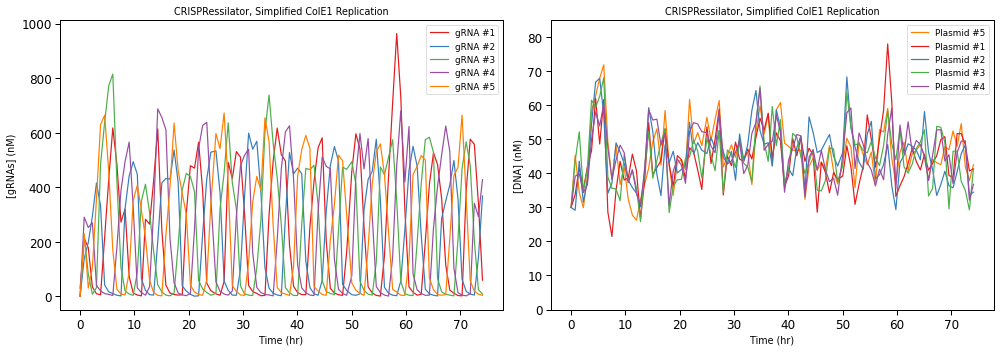

In [58]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in simple_bp_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
#     gRNA_idx = bp_model.get_species2index()[f"g{i}"]
#     dCas_idx = bp_model.get_species2index()[f"dCas:g{i}"]
#     dna_idx = bp_model.get_species2index()[f"DNA{prev_i}:g{i}"]
#     bare_dna_idx = bp_model.get_species2index()[f"DNA{prev_i}"]

#     bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
#     dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
#     dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
#     bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    
#     total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
#     total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}:g{i}"]
    dna_suffixes = ["", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}:g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[simple_bp_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[simple_bp_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    min_t = 0#int(len(plotting_ts)/2)
    plt.plot(plotting_ts[min_t:-1], total_gRNA[min_t:-1], label = f"gRNA #{i}", 
                color = color_list[i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts[min_t:-1], total_dna[min_t:-1], label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRessilator, Simplified ColE1 Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0, 85)
plt.title("CRISPRessilator, Simplified ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()